In [ ]:

!pip install scikit-learn pandas matplotlib openpyxl

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_curve, auc
)



In [2]:
from google.colab import files

In [14]:
df=files.upload()

Saving ml model.xlsx to ml model (2).xlsx


Top 20 labels (by overall count):
 ['26', '25', '24', '23', '27', '22', '28', '21', '29', '30', '20', '31', '32', '19', '33', '34', '35', '18', '36', '37']


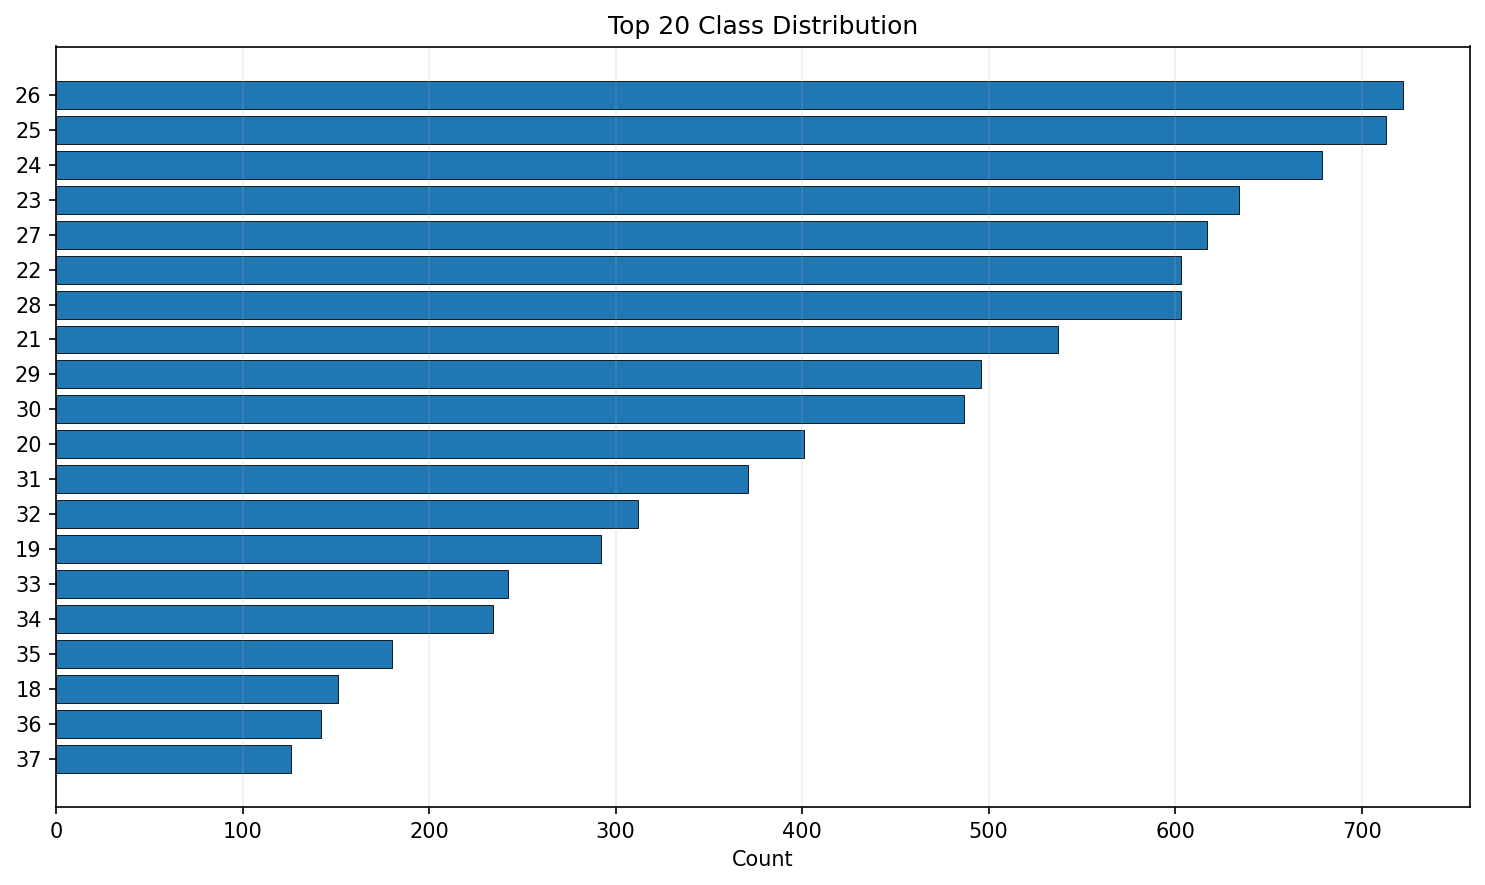


Test samples: 2000, samples where both true & pred in top 20: 1712


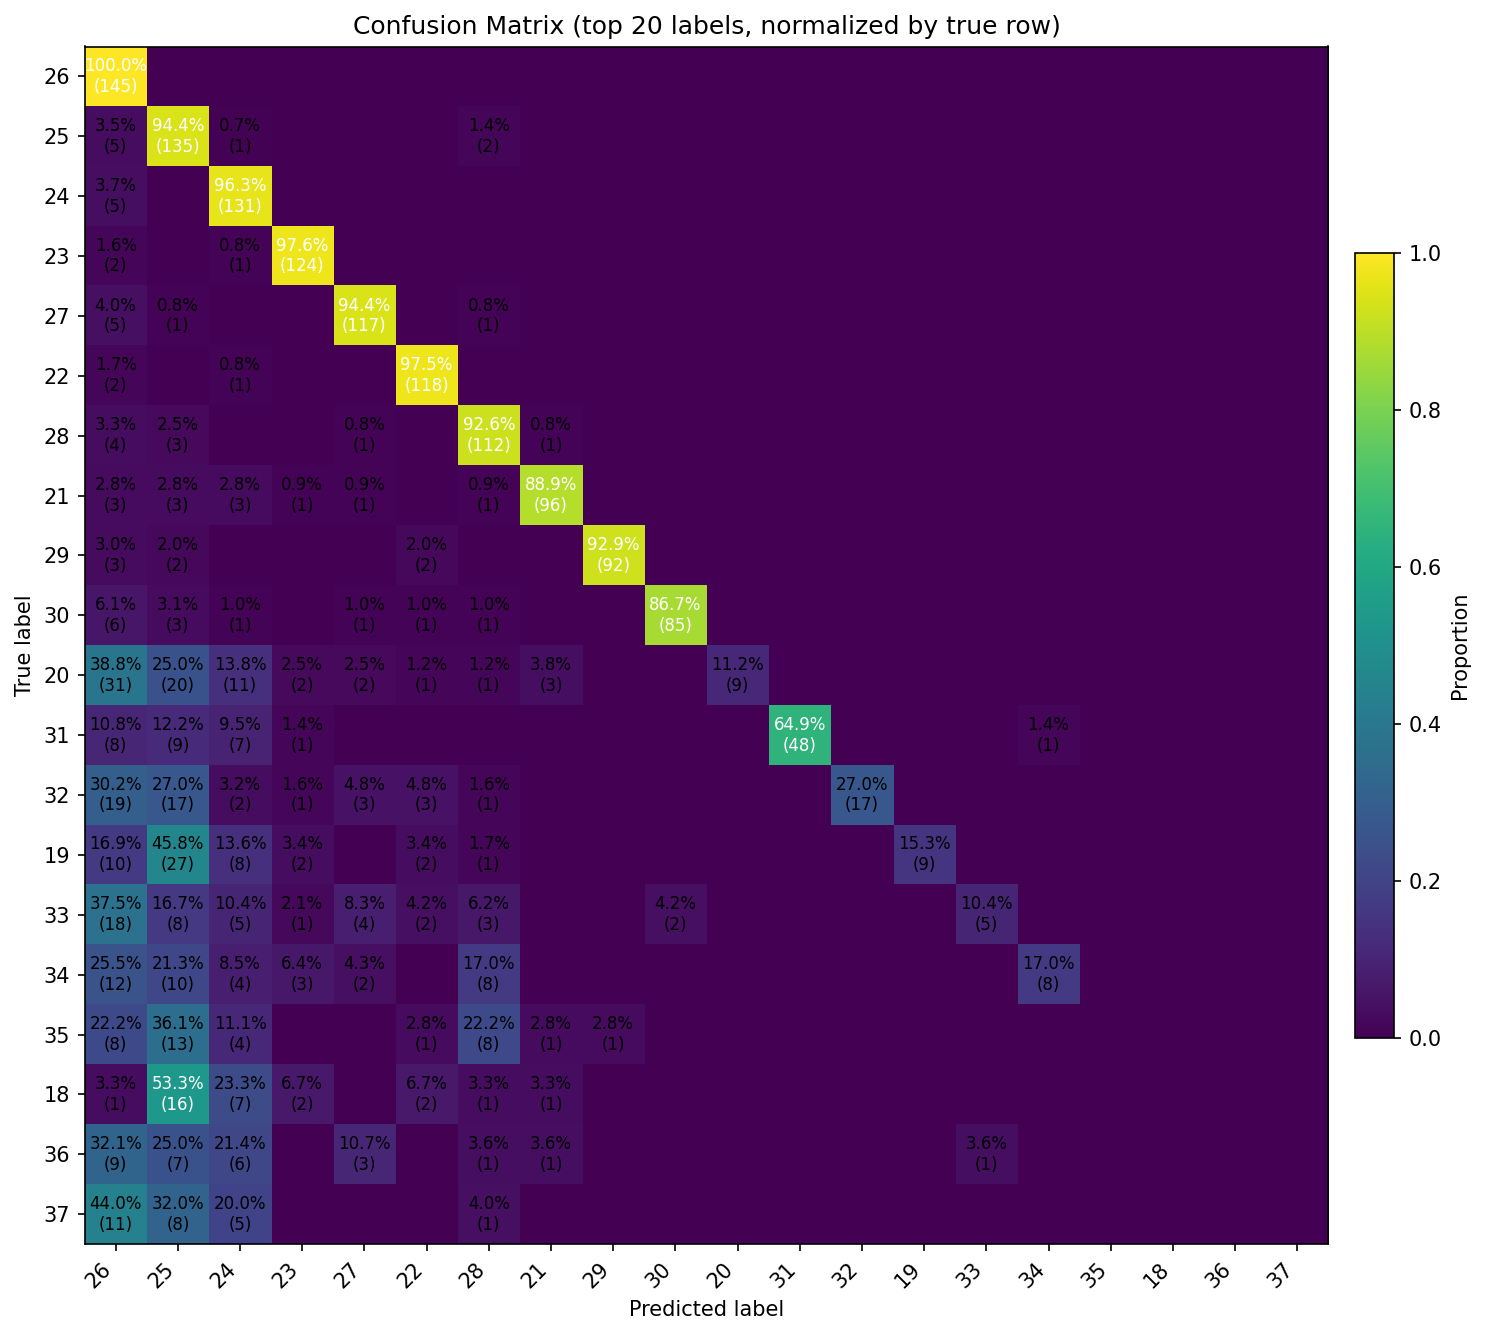


Classification report (restricted to shown labels):
              precision    recall  f1-score   support

          26       0.47      1.00      0.64       145
          25       0.48      0.94      0.64       143
          24       0.66      0.96      0.79       136
          23       0.91      0.98      0.94       127
          27       0.87      0.94      0.91       124
          22       0.89      0.98      0.93       121
          28       0.79      0.93      0.85       121
          21       0.93      0.89      0.91       108
          29       0.99      0.93      0.96        99
          30       0.98      0.87      0.92        98
          20       1.00      0.11      0.20        80
          31       1.00      0.65      0.79        74
          32       1.00      0.27      0.42        63
          19       1.00      0.15      0.26        59
          33       0.83      0.10      0.19        48
          34       0.89      0.17      0.29        47
          35       0.00     

In [18]:
# Clean, readable plotting of top classes + confusion matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

# --- CONFIG ---
top_k = 20                        # <= change this to show more/less classes
fig_dpi = 150
bar_figsize = (10, 6)
cm_figsize = (10, 9)
save_to_files = True              # set False if you don't want PNG files saved
prefix = "clean_output"           # file prefix for saved images


try:
    pred = pred_enc  # encoded preds if you have them
    # If pred_enc is numeric we need the string labels; prefer to compute preds again below.
    raise NameError  # force recompute to ensure string labels alignment (safer)
except Exception:
    # Recompute predictions in string-label space (works even if model was trained on encoded labels)
    # Convert X_test_text (pandas Series) to vectorized form if needed:
    X_test_vec_local = vectorizer.transform(X_test_text)
    # predict encoded labels (ints)
    pred_enc_local = model.predict(X_test_vec_local)
    # If you have a LabelEncoder 'le' used earlier, inverse transform to strings:
    try:
        pred_labels = le.inverse_transform(pred_enc_local)
    except Exception:
        # fallback: use pred_enc_local as-is (strings) if model returned strings
        pred_labels = pred_enc_local
    pred = np.array(pred_labels)

# ensure y_test is numpy array of strings
y_test_arr = np.array(y_test).astype(str)
pred_arr = np.array(pred).astype(str)

# --- Select top_k labels by frequency in the full training/merged labels (y_merged) ---
label_counts = pd.Series(y_merged).value_counts()
top_labels = label_counts.nlargest(top_k).index.astype(str).tolist()
print(f"Top {top_k} labels (by overall count):\n", top_labels)

# --- Horizontal bar chart for top classes (counts) ---
top_counts = label_counts.loc[top_labels]  # preserve order
plt.figure(figsize=bar_figsize, dpi=fig_dpi)
plt.barh(np.arange(len(top_counts)), top_counts.values, edgecolor='black', linewidth=0.4)
plt.yticks(np.arange(len(top_counts)), top_counts.index)
plt.gca().invert_yaxis()  # largest on top
plt.xlabel("Count")
plt.title(f"Top {top_k} Class Distribution")
plt.grid(axis='x', alpha=0.2)
plt.tight_layout()
if save_to_files:
    plt.savefig(f"{prefix}_top{top_k}_class_distribution.png", dpi=fig_dpi, bbox_inches='tight')
plt.show()

# --- Confusion matrix limited to samples where BOTH true and predicted labels are in top_labels ---
mask_true_in_top = np.isin(y_test_arr, top_labels)
mask_pred_in_top = np.isin(pred_arr, top_labels)
mask_both = mask_true_in_top & mask_pred_in_top
num_kept = mask_both.sum()
num_total = len(y_test_arr)
print(f"\nTest samples: {num_total}, samples where both true & pred in top {top_k}: {num_kept}")

if num_kept < 1:
    print("No test rows left with both true & predicted labels in top labels. Try increasing top_k or use a different selection.")
else:
    y_true_top = y_test_arr[mask_both]
    y_pred_top = pred_arr[mask_both]

    # compute confusion matrix with labels in the same order as top_labels
    cm = confusion_matrix(y_true_top, y_pred_top, labels=top_labels)

    # Normalize rows -> percent of true-class samples predicted as each class
    with np.errstate(all='ignore'):
        cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    cm_norm = np.nan_to_num(cm_norm)  # replace NaN rows (if any) with 0

    # Plot normalized confusion matrix as annotated heatmap
    plt.figure(figsize=cm_figsize, dpi=fig_dpi)
    im = plt.imshow(cm_norm, interpolation='nearest', aspect='auto', cmap='viridis')
    plt.title(f"Confusion Matrix (top {top_k} labels, normalized by true row)")
    plt.colorbar(im, fraction=0.03, pad=0.02, label='Proportion')

    # ticks and labels (rotate outer labels to be readable)
    tick_pos = np.arange(len(top_labels))
    plt.xticks(tick_pos, top_labels, rotation=45, ha='right')
    plt.yticks(tick_pos, top_labels)

    # annotate with percentages (only show if > 0)
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            val = cm_norm[i, j]
            if val > 0:
                txt = f"{val*100:.1f}%\n({cm[i,j]})"
                plt.text(j, i, txt, ha='center', va='center',
                         color='white' if val > 0.5 else 'black', fontsize=8)

    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    if save_to_files:
        plt.savefig(f"{prefix}_confusion_top{top_k}.png", dpi=fig_dpi, bbox_inches='tight')
    plt.show()

    # Print a compact classification report for these labels only
    print("\nClassification report (restricted to shown labels):")
    from sklearn.metrics import classification_report
    print(classification_report(y_true_top, y_pred_top, labels=top_labels, zero_division=0))



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ran

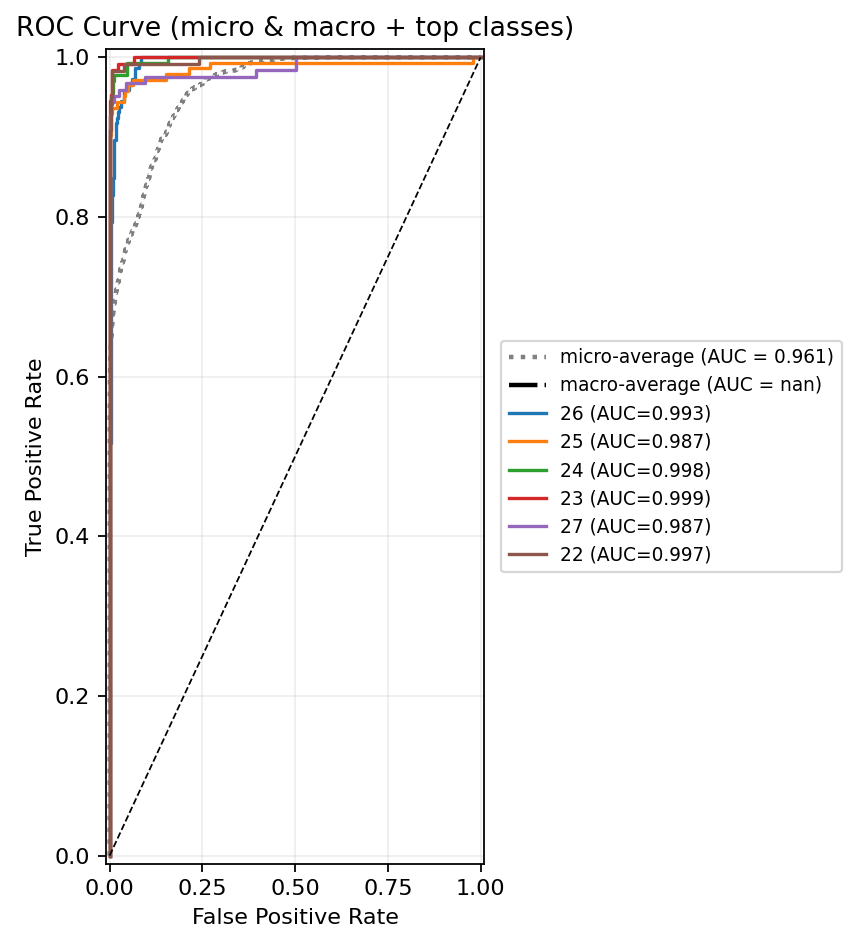

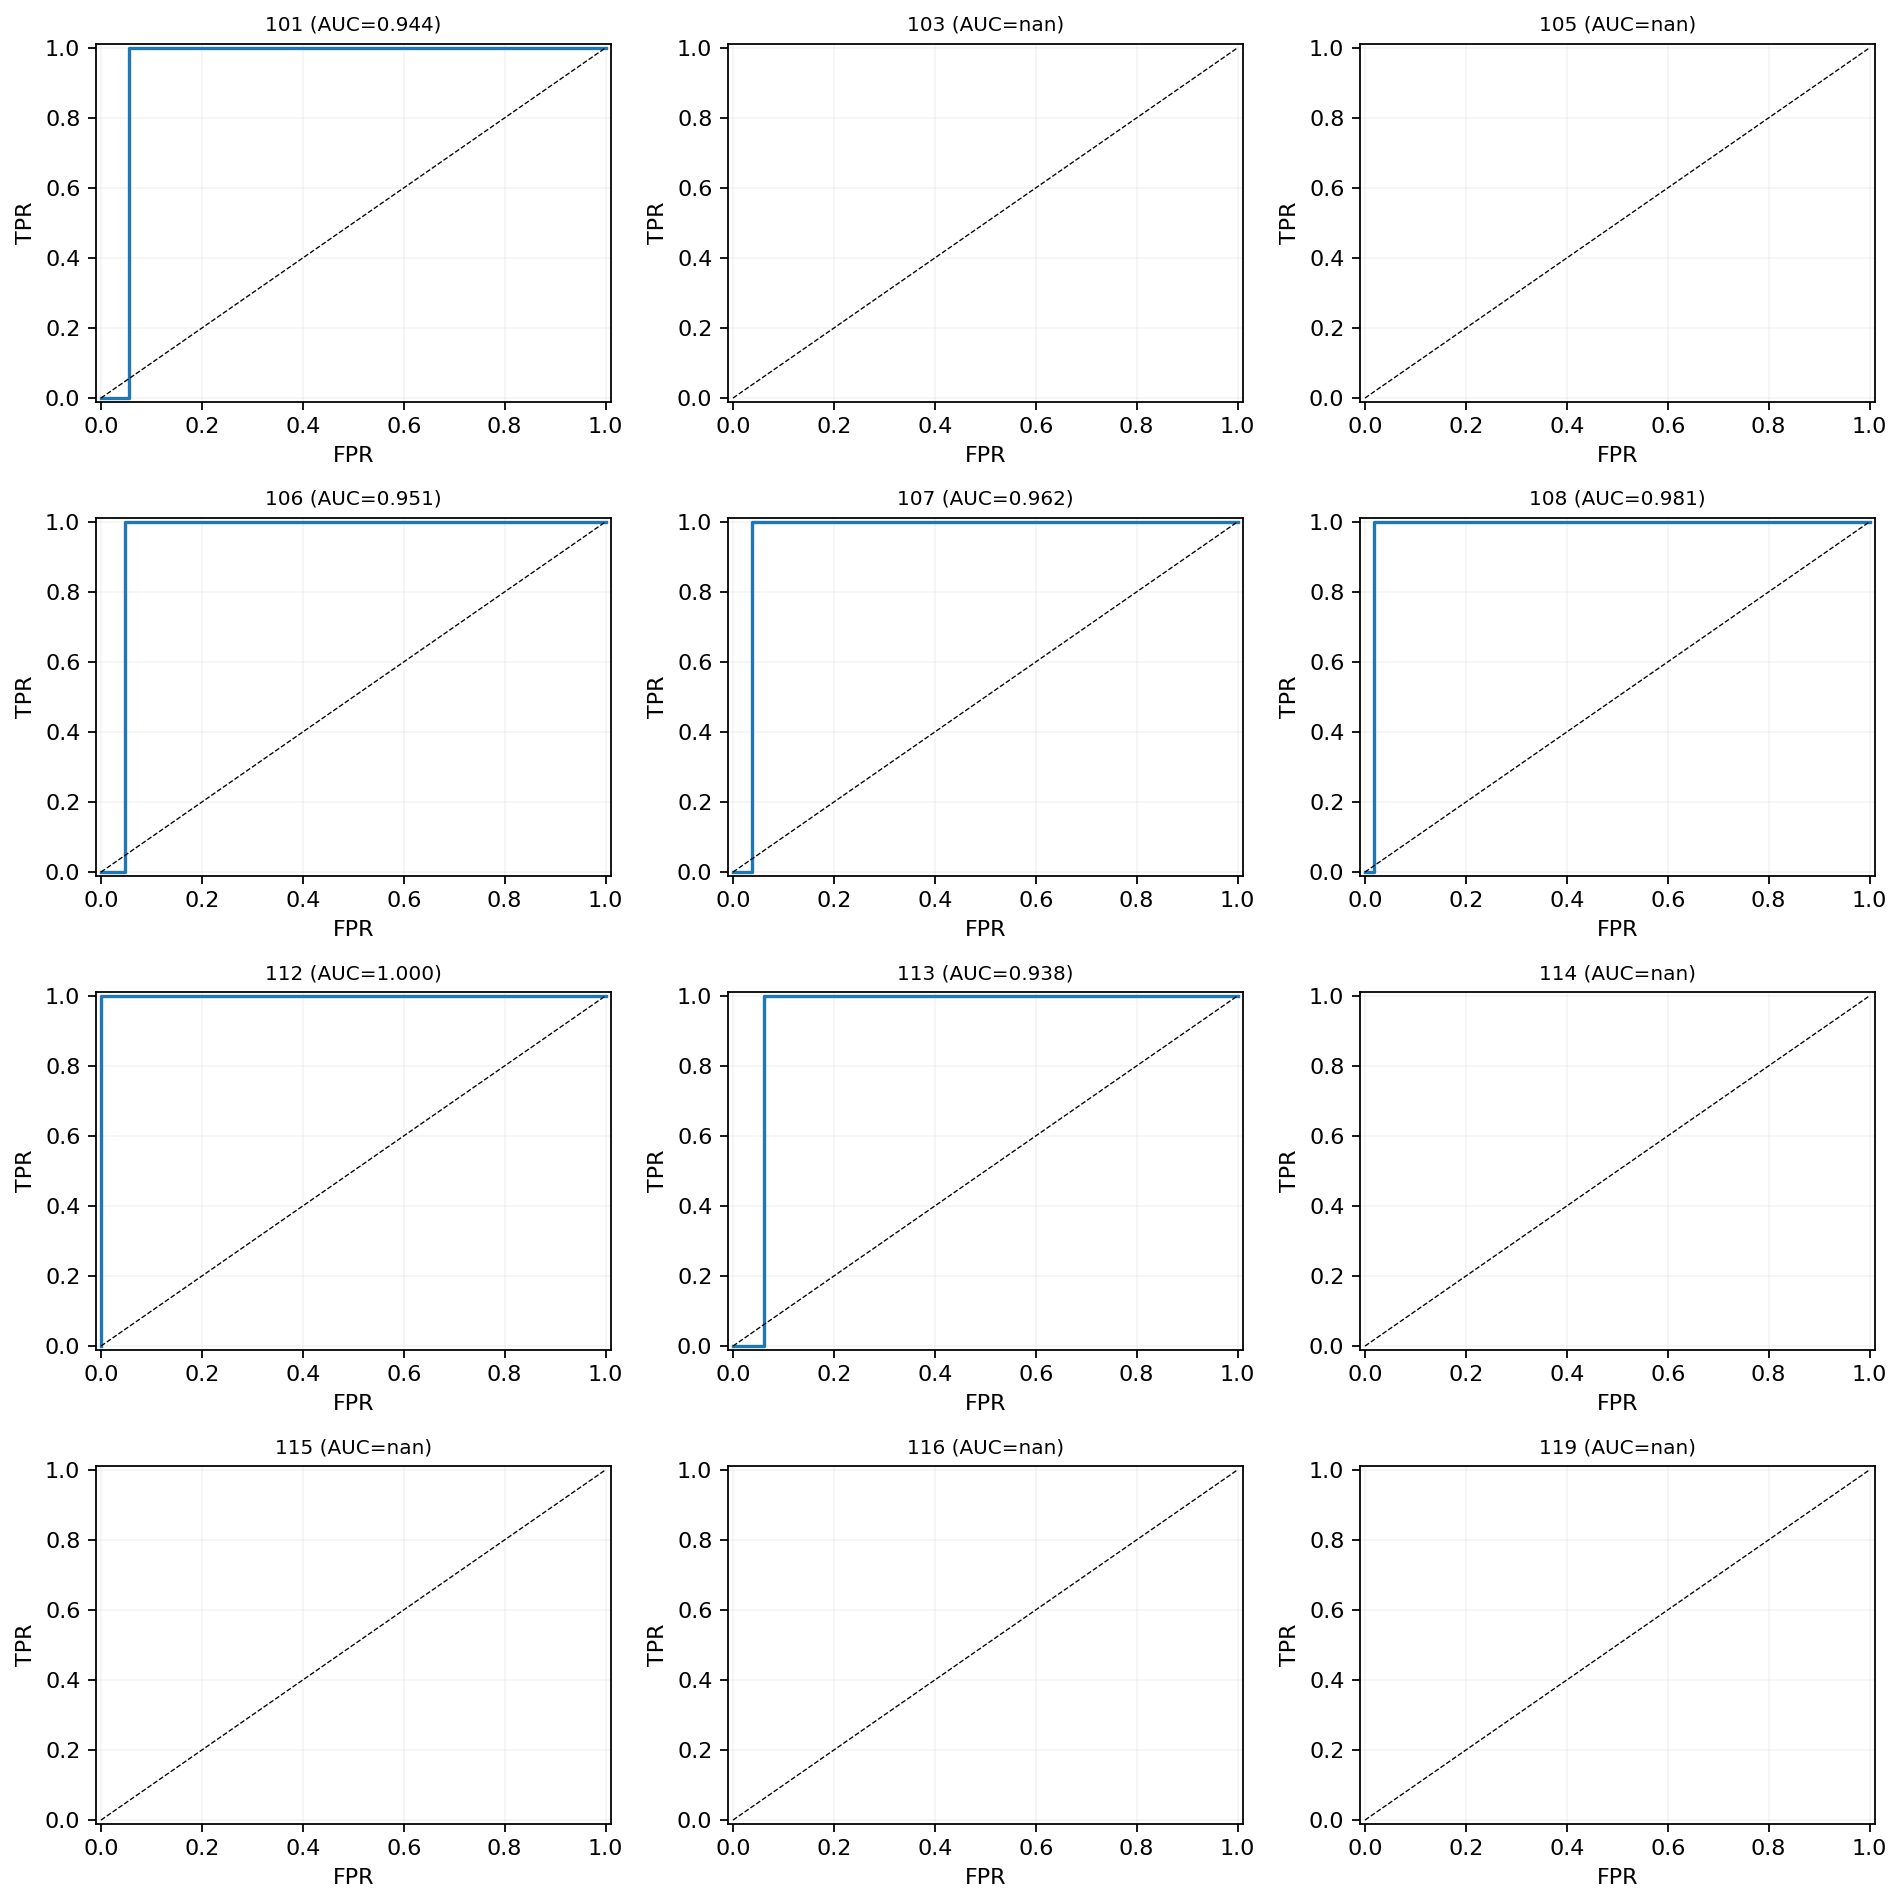

Saved files: clean_roc_main.png, clean_roc_per_class_grid.png


In [20]:
# ---- Clean ROC plotting: binary & multiclass (One-vs-Rest) ----
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# -------- Config --------
main_dpi = 160
main_figsize = (7, 6)
perclass_figsize = (10, 8)        # only used when saving separate per-class grid
max_lines = 6                     # maximum individual class curves to draw on main plot (besides micro/macro)
max_grid = 12                     # max classes to show in grid of small ROC plots (increase if you want many small plots)
save_png = True
prefix = "clean_roc"
linewidth = 2.0

# -------- Prepare inputs (make robust) --------
# X_test_text : pandas Series or list of raw text rows used for test
# y_test : array-like of true labels (strings or ints)
# model, vectorizer : trained objects

# Ensure y_test is numpy array of strings
y_test_arr = np.array(y_test).astype(str)

# ensure label encoder exists or create from model / y_train/le if available
try:
    classes = list(le.classes_)
except Exception:
    # Build LabelEncoder from union of y_test and any classes learned by the model if possible
    le = LabelEncoder()
    le.fit(y_test_arr)   # minimal fallback
    classes = list(le.classes_)

n_classes = len(classes)
if n_classes < 2:
    raise ValueError("Need at least 2 classes to compute ROC.")

# Vectorize test set
X_test_vec = vectorizer.transform(X_test_text)

# ---------- get score matrix (n_samples, n_classes) ----------
scores = None
# prefer predict_proba
if hasattr(model, "predict_proba"):
    try:
        scores = model.predict_proba(X_test_vec)
    except Exception:
        scores = None
# fallback to decision_function
if scores is None and hasattr(model, "decision_function"):
    dec = model.decision_function(X_test_vec)
    # decision_function shapes vary; convert to (n_samples, n_classes) if binary
    if dec.ndim == 1:
        dec = np.vstack([-dec, dec]).T
    scores = dec

if scores is None:
    raise RuntimeError("Model lacks predict_proba and decision_function — cannot compute ROC.")

# If scores columns don't match classes count, attempt safe adjustment
if scores.shape[1] != n_classes:
    # try to align if LabelEncoder was used when training (common case)
    # Otherwise, if fewer columns, pad with very small values (so ROC can still compute)
    if scores.shape[1] < n_classes:
        pad = np.zeros((scores.shape[0], n_classes - scores.shape[1]))
        scores = np.hstack([scores, pad])
    else:
        # More score columns than classes: truncate to n_classes
        scores = scores[:, :n_classes]

# Binarize y_test to shape (n_samples, n_classes) in label-encoder order
y_test_bin = label_binarize(y_test_arr, classes=classes)

# ---------- compute per-class ROC and AUC ----------
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    try:
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    except ValueError:
        # if a class has no positive samples in y_test_bin[:,i], set empty arrays
        fpr[i], tpr[i], roc_auc[i] = np.array([0.0, 1.0]), np.array([0.0, 1.0]), 0.0

# micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# macro-average (interpolated)
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# ---------- Choose top classes to show (by support in y_test) ----------
# show top by test-sample counts, to focus on meaningful curves
test_counts = pd.Series(y_test_arr).value_counts()
top_classes = test_counts.nlargest(max_lines).index.astype(str).tolist()
# Ensure they are in label encoder order for consistency
top_indices = [classes.index(c) for c in top_classes if c in classes]

# ---------- Main ROC plot (micro, macro, + up to max_lines class curves) ----------
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=main_figsize, dpi=main_dpi)
plt.plot(fpr["micro"], tpr["micro"],
         label=f"micro-average (AUC = {roc_auc['micro']:.3f})",
         linestyle=':', linewidth=linewidth, color='gray')
plt.plot(fpr["macro"], tpr["macro"],
         label=f"macro-average (AUC = {roc_auc['macro']:.3f})",
         linestyle='-.', linewidth=linewidth, color='black')

colors = cycle(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:olive'])
for idx, color in zip(top_indices, colors):
    plt.plot(fpr[idx], tpr[idx], lw=1.5, color=color,
             label=f"{classes[idx]} (AUC={roc_auc[idx]:.3f})")

plt.plot([0, 1], [0, 1], 'k--', lw=0.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (micro & macro + top classes)')
# place legend outside to the right
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize='small')
plt.grid(alpha=0.2)
plt.tight_layout(rect=(0,0,0.78,1))   # leave room on right for legend
if save_png:
    plt.savefig(f"{prefix}_main.png", dpi=main_dpi, bbox_inches='tight')
plt.show()

# ---------- Optional: Per-class small subplot grid for more detail (up to max_grid) ----------
import math, pandas as pd
n_show = min(n_classes, max_grid)
cols = 3
rows = math.ceil(n_show / cols)
plt.figure(figsize=(cols*4, rows*3), dpi=main_dpi)
for i in range(n_show):
    plt.subplot(rows, cols, i+1)
    plt.plot(fpr[i], tpr[i], lw=1.5)
    plt.plot([0, 1], [0, 1], 'k--', lw=0.6)
    plt.xlim([-0.01,1.01]); plt.ylim([-0.01,1.01])
    auc_i = roc_auc.get(i, 0.0)
    plt.title(f"{classes[i]} (AUC={auc_i:.3f})", fontsize=9)
    plt.xlabel('FPR'); plt.ylabel('TPR')
    plt.grid(alpha=0.12)
plt.tight_layout()
if save_png:
    plt.savefig(f"{prefix}_per_class_grid.png", dpi=main_dpi, bbox_inches='tight')
plt.show()

print("Saved files:" + (f" {prefix}_main.png, {prefix}_per_class_grid.png" if save_png else " (not saving)"))
